## SSMI Ice data
### Cartopy quicklook

This notebook provides guidance to visualize SSMI data after it has been processed from raw binary data to csv data with columns of ice_concentration, latitude, and longitude.  It regrids the data to the users choice (default = 0.25x0.25 degree) by declaring the number of columns of latitude and longitude.

There is also timing components built in to see if and where the ingest/gridding/plotting can be spead up

__pyversion__==3.7   
__author__==S.Bell

In [19]:
import numpy as np
import datetime

import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import timeit

In [20]:
#define the basic map projection information and figure size

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(10.5, 10.5),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

#download land mask
# 50m is a good balance between dataset size and land feature resolution
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

### Define boundaries and cycle through all Bootstrap/NRT data

We want to compare to the Daily Bering Sea ice extent during the past fourty years (data from the NSIDC Regional Sea Ice Index) which does a more comprehensive job of masking out the basin then the simple grid.  A 5day trailing average is applied to the regional extent product.

In [21]:
import glob
#boundaries=[65,80,140,165,'RArctic'] #RArctic
#boundaries=[65,80,-150,-120,'CArctic'] #CArctic
boundaries=[50,80,165,-150,'USArctic'] #USArctic
#boundaries=[65,85,7,75,'BarentsAlt'] #KWood BarentsAlt

int_date=True

## watch signs +E/-W and overlapping the dateline is tricky
for y in range(2020,2021):
    year=str(y)
    print(y)
    if y <=2019:
        path = "/Volumes/RetiredDowndraft/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/bt_"+year+"*.csv"
    else:
        path = "/Volumes/RetiredDowndraft/in_and_outbox/data_sets/nrt_nasatime_seaice/*"+year+"*.csv"
    for fname in sorted(glob.glob(path)):

        df = pd.read_csv(fname)

        ### set a range of lats and lons - 178E to 155W
        dfext = df.copy()
        dfext.drop(dfext.loc[((dfext['latitude']<=boundaries[0]) | (dfext['latitude']>=boundaries[1]))].index, inplace=True)
        #178E for BS boundary by Phyllis
        #165E for BS total boundary (estimate to not include any Sea of Oktosk)

        if int_date:
            dfext.drop(dfext.loc[((dfext['longitude']<boundaries[2]) & (dfext['longitude']>boundaries[3]))].index, inplace=True)
        else:
            dfext.drop(dfext.loc[((dfext['longitude']<boundaries[2]))].index, inplace=True)
            dfext.drop(dfext.loc[(dfext['longitude']>boundaries[3])].index, inplace=True)  
            
        dfext.drop(dfext.loc[dfext['ice_conc']<15].index, inplace=True)
        dfext.drop(dfext.loc[dfext['ice_conc']==np.nan].index, inplace=True)

        new_days = open(boundaries[4]+"_iceextent."+year+".csv",'a')
        new_days.write((fname+','+str(dfext['grid_area'].sum())+'\n'))
        #print(fname,(dfext['grid_area'].sum()))
        new_days.close()

2020


In [5]:
for y in range(1978,2020):
    year=str(y)

    fin = boundaries[4]+'_iceextent.'+year+'.csv'
    fid = pd.read_csv(fin,names=['file','ice_extent'])
    fid['doy'] = fid['file']

    for index, rows in fid.iterrows():
        fid['doy'][index] = int(datetime.datetime.strptime(rows['doy'].split('bt_')[-1].split('_')[0],
                                                           '%Y%m%d').strftime('%j'))
    fid = fid.merge(how='right', 
              on='doy', 
              right = pd.DataFrame({'doy':np.arange(fid.iloc[0]['doy'], 
                                                    367, 
                                                    1)})).reset_index().drop(['index'], 
                                                                             axis=1).sort_values(by=['doy'])
    fid.to_csv(fin.replace('.csv','doy.csv'),columns=['doy','ice_extent'])

In [22]:
for y in range(2020,2021):
    year=str(y)

    fin = boundaries[4]+'_iceextent.'+year+'.csv'
    fid = pd.read_csv(fin,names=['file','ice_extent'])
    fid['doy'] = fid['file']

    for index, rows in fid.iterrows():
        fid['doy'][index] = int(datetime.datetime.strptime(rows['doy'].split('nt_')[-1].split('_')[0],
                                                           '%Y%m%d').strftime('%j'))
    fid = fid.merge(how='right', 
              on='doy', 
              right = pd.DataFrame({'doy':np.arange(fid.iloc[0]['doy'], 
                                                    367, 
                                                    1)})).reset_index().drop(['index'], 
                                                                             axis=1).sort_values(by=['doy'])
    fid.to_csv(fin.replace('.csv','doy.csv'),columns=['doy','ice_extent'])

/Users/bell/miniconda3/envs/holoviz/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


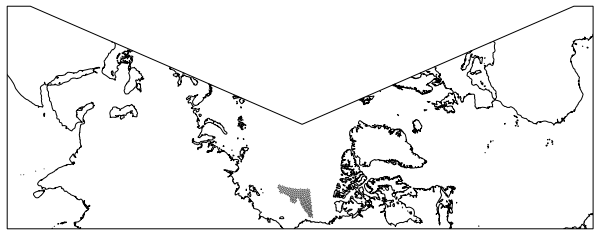

In [23]:
# map it all

extent = boundaries
projection=ccrs.LambertConformal(central_longitude=200.0)
transformation=ccrs.PlateCarree()
fig,ax = make_map(projection=projection)

ax.plot(dfext.longitude,dfext.latitude,'k.',markersize=.25,transform=transformation)
ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent([0,90,0,360])

In [36]:
### read files and build dataframe with doy as index
import os

df = pd.DataFrame(index=range(1,367))
fdir = '/Volumes/RetiredDowndraft/in_and_outbox/Ongoing_Analysis/SeaIce_Analysis/KWood_Regions/'
for files in sorted(os.listdir( fdir )):
    if ('doy' in files) and ('USArctic' in files):
        print(files)
        dft = pd.read_csv(fdir+files,usecols=['doy','ice_extent'],index_col='doy')
        dft.columns= [files.split('doy')[0].split('.')[1]]
        df = pd.concat([df,dft],axis=1)
        
        df.to_csv(fdir+files.split('.')[0]+'.csv')

USArctic_iceextent.1978doy.csv
USArctic_iceextent.1979doy.csv
USArctic_iceextent.1980doy.csv
USArctic_iceextent.1981doy.csv
USArctic_iceextent.1982doy.csv
USArctic_iceextent.1983doy.csv
USArctic_iceextent.1984doy.csv
USArctic_iceextent.1985doy.csv
USArctic_iceextent.1986doy.csv
USArctic_iceextent.1987doy.csv
USArctic_iceextent.1988doy.csv
USArctic_iceextent.1989doy.csv
USArctic_iceextent.1990doy.csv
USArctic_iceextent.1991doy.csv
USArctic_iceextent.1992doy.csv
USArctic_iceextent.1993doy.csv
USArctic_iceextent.1994doy.csv
USArctic_iceextent.1995doy.csv
USArctic_iceextent.1996doy.csv
USArctic_iceextent.1997doy.csv
USArctic_iceextent.1998doy.csv
USArctic_iceextent.1999doy.csv
USArctic_iceextent.2000doy.csv
USArctic_iceextent.2001doy.csv
USArctic_iceextent.2002doy.csv
USArctic_iceextent.2003doy.csv
USArctic_iceextent.2004doy.csv
USArctic_iceextent.2005doy.csv
USArctic_iceextent.2006doy.csv
USArctic_iceextent.2007doy.csv
USArctic_iceextent.2008doy.csv
USArctic_iceextent.2009doy.csv
USArctic

In [37]:

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

### specify primary bulk figure parameters
fontsize = 20
labelsize = 16
#plotstyle = 'seaborn'
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 1
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 1
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

In [38]:
### after previous files are ingested into an excel file
### All BS


fid = '/Volumes/RetiredDowndraft/in_and_outbox/Ongoing_Analysis/SeaIce_Analysis/KWood_Regions/AltArcticRegions_iceextent.xlsx'
page = 'USArctic_iceextent'

dfe = pd.read_excel(fid,sheet_name=page)

dfe = dfe.interpolate()
dfe['doy_y2'] = dfe.index+365

dfmean = dfe.copy()
dfmean.drop(columns=[2020,'Unnamed: 0'],inplace=True)
dfmean['avg'] = dfmean.drop('doy_y2',axis=1).drop(59,axis=0).mean(axis=1)



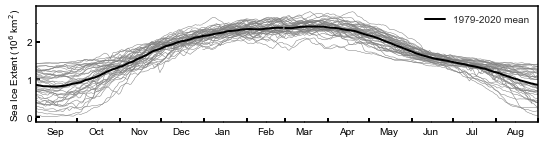

In [44]:
# start at Sep 1 (244)
# Area Extent in x10^6 km^2

fig = plt.figure(1,figsize=(9,2.125))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)
for yy in range(1978,2020,1):
    plt.plot(dfe.index,dfe[yy]/1e6,c='gray',linewidth=.5,label='')
    plt.plot(dfe['doy_y2'],dfe[yy]/1e6,c='gray',linewidth=.5,label='')
    
#Fall
l1 = ax1.plot(dfmean.index,dfmean['avg']/1e6,'k',linewidth=2,label='1979-2020 mean')

#Spring
plt.plot(dfmean['doy_y2'],dfmean['avg']/1e6,'k',linewidth=2,label='')


plt.legend(loc='best')
plt.xticks((0,31,61,92,122,153,183,214,245,275,306,336,
               0+365,31+365,61+365,92+365,122+365,153+365,
               183+365,214+365,245+365,275+365,306+365,336+365),)
ax1.set_xlim([244,244+365])
#plt.yticks(np.arange(0,1.2,.4))
ax1.tick_params(axis='y',which='both',bottom='on')

ax1.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
ax1.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax1.xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax1.xaxis.set_major_formatter(ticker.NullFormatter())
ax1.xaxis.set_minor_formatter(DateFormatter('%b'))
ax1.xaxis.set_major_formatter(DateFormatter(''))
ax1.xaxis.set_tick_params(which='major', pad=15)
ax1.xaxis.set_tick_params(which='minor', pad=5)
    
plt.ylabel('Sea Ice Extent (10$^{6}$ km$^{2}$)')
fig.savefig('USArcticExtent_timeseries.png',dpi=300)

/Users/bell/miniconda3/envs/holoviz/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


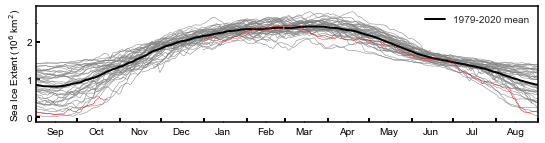

In [45]:
# start at Sep 1 (244)
# Area Extent in x10^6 km^2
# current ice season in red

fig = plt.figure(1,figsize=(9,2.125))
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)
for yy in range(1978,2020,1):
    plt.plot(dfe.index,dfe[yy]/1e6,c='gray',linewidth=.5,label='')
    plt.plot(dfe['doy_y2'],dfe[yy]/1e6,c='gray',linewidth=.5,label='')
    
#Fall
l1 = ax1.plot(dfmean.index,dfmean['avg']/1e6,'k',linewidth=2,label='1979-2020 mean')

#Spring
plt.plot(dfmean['doy_y2'],dfmean['avg']/1e6,'k',linewidth=2,label='')

#current year
cyear=2020
dfe[cyear][dfe[cyear].index > int(datetime.datetime.strftime(datetime.datetime(2020,10,22),'%j'))] = np.nan

plt.plot(dfe.index,dfe[2020]/1e6,c='red',linewidth=.5,label='')
plt.plot(dfe['doy_y2'],dfe[2020]/1e6,c='red',linewidth=.5,label='')
    
plt.legend(loc='best')
plt.xticks((0,31,61,92,122,153,183,214,245,275,306,336,
               0+365,31+365,61+365,92+365,122+365,153+365,
               183+365,214+365,245+365,275+365,306+365,336+365),)
ax1.set_xlim([244,244+365])
#plt.yticks(np.arange(0,1.2,.4))
ax1.tick_params(axis='y',which='both',bottom='on')

ax1.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
ax1.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax1.xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax1.xaxis.set_major_formatter(ticker.NullFormatter())
ax1.xaxis.set_minor_formatter(DateFormatter('%b'))
ax1.xaxis.set_major_formatter(DateFormatter(''))
ax1.xaxis.set_tick_params(which='major', pad=15)
ax1.xaxis.set_tick_params(which='minor', pad=5)
    
plt.ylabel('Sea Ice Extent (10$^{6}$ km$^{2}$)')
fig.savefig('USArcticExtent_timeseries_wcurrentcalyear.png',dpi=300)